In [9]:
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
import numpy as np
import holidays

import matplotlib.pyplot as plt

import sys
sys.path.append("../")
import asset.MyPlot as mp
import asset.DataSupply as ds

import warnings
warnings.filterwarnings("ignore")

In [3]:
# df_rain_historical, dct_areas = ds.GetRainfallByPumps(
#     ["haarsteeg"]
# )

# df_dry = GenerateMLdata(
#     "bokhoven",
#     87.85909502482393,
#     -4.1,
#     df_rain_historical,
#     dct_areas
# )

df_dry = pd.read_csv(
    "../asset/data/model_data_haarsteeg.csv", index_col=0, parse_dates=True
)

In [4]:
df_dry

,haarsteeg_in_flow_vol,haarsteeg_flow_value,haarsteeg_level_value,haarsteeg_last_in_flow_vol,haarsteeg_vol_remain
end_hour,,,,,
2019-09-01 19:00:00,359.490130,311.270667,-2.2550,NaN,162.100030
2019-09-01 20:00:00,216.133374,233.197500,-1.9000,359.490130,193.290009
2019-09-01 21:00:00,556.148072,476.507167,-1.9700,216.133374,187.139872
2019-09-03 04:00:00,498.600364,343.505333,-2.4200,556.148072,147.603280
2019-09-03 05:00:00,64.796083,5.790000,-1.6825,498.600364,212.399362
...,...,...,...,...,...
2020-07-31 19:00:00,358.465108,366.984667,-2.4600,273.827513,144.088916
2020-07-31 20:00:00,446.324203,383.887167,-1.9600,358.465108,188.018463
2020-07-31 21:00:00,277.634740,276.331167,-1.5500,446.324203,224.040692


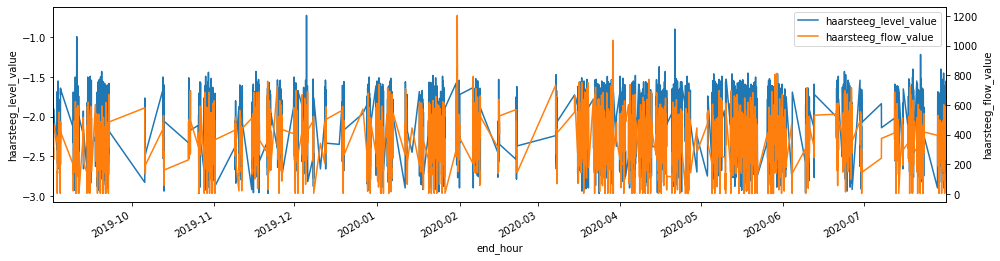

In [5]:
mp.PlotMulti(df_dry[["haarsteeg_level_value", "haarsteeg_flow_value"]], figsize=(16, 4))

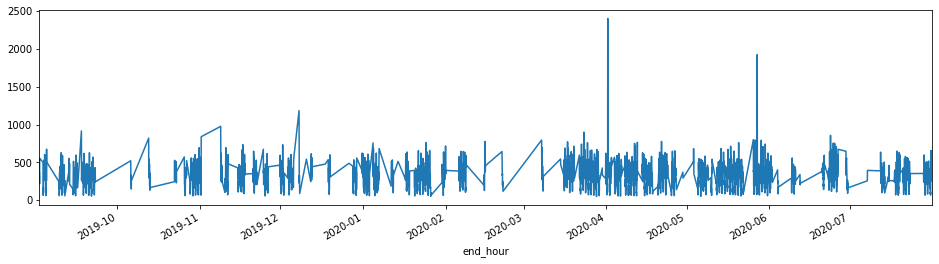

In [11]:
df_grouped = df_dry.groupby("end_hour", as_index=True).sum()[["haarsteeg_in_flow_vol", "haarsteeg_flow_value"]]
df_grouped["haarsteeg_in_flow_vol"].plot(figsize=(16, 4))

In [12]:
nl_holidays = holidays.NL()

df_grouped["hour"] = df_grouped.index.hour
df_grouped["day"] = df_grouped.index.day
df_grouped["weekday"] = df_grouped.index.weekday
df_grouped["month"] = df_grouped.index.month
df_grouped["year"] = df_grouped.index.year
df_grouped["is_holiday"] = [int(i.date() in nl_holidays) for i in df_grouped.index]
df_grouped["haarsteeg_last_in_flow_vol"] = df_grouped["haarsteeg_in_flow_vol"].shift()
df_grouped["covid"] = df_grouped.index > "2020-03-15 00:00:00"

In [13]:
df_grouped.head(3)

,haarsteeg_in_flow_vol,haarsteeg_flow_value,hour,day,weekday,month,year,is_holiday,haarsteeg_last_in_flow_vol,covid
end_hour,,,,,,,,,,
2019-09-01 19:00:00,359.490130,311.270667,19,1,6,9,2019,0,NaN,False
2019-09-01 20:00:00,216.133374,233.197500,20,1,6,9,2019,0,359.490130,False
2019-09-01 21:00:00,556.148072,476.507167,21,1,6,9,2019,0,216.133374,False


In [14]:
# estimators
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

import xgboost as xgb
from sklearn.linear_model import ElasticNet

# evaluators
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [16]:
seed = 666

data = df_grouped.copy()
X = data.iloc[1:, 2:]
y = data.iloc[1:, 0]

best_sfs = None
best_nmae = float("-inf")
for i in range(1, 8):
    sfs_temp = SFS(
        RandomForestRegressor(random_state=seed),
        k_features=i,
        forward=True,
        floating=False,
        scoring="neg_mean_absolute_error",
        cv=0,
    )
    sfs_temp.fit(X, y)
    print(f"""{i} features, with neg_mean_absolute_error: {sfs_temp.k_score_}""")
    if sfs_temp.k_score_ > best_nmae:
        best_sfs = sfs_temp
        best_nmae = sfs_temp.k_score_


print(f"best: {best_sfs.k_feature_names_}")
X_new = best_sfs.transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.2, random_state=seed
)

1 features, with neg_mean_absolute_error: -66.80587379594394
2 features, with neg_mean_absolute_error: -38.540480408357055
3 features, with neg_mean_absolute_error: -35.384933103600645
4 features, with neg_mean_absolute_error: -34.437512405496754
5 features, with neg_mean_absolute_error: -34.01965318876888
6 features, with neg_mean_absolute_error: -33.9790003549429
7 features, with neg_mean_absolute_error: -33.625887856196904
best: ('hour', 'day', 'weekday', 'month', 'year', 'is_holiday', 'haarsteeg_last_in_flow_vol')


In [17]:
# params for rf
min_samples_split = [
    10, 20,30
]
min_samples_leaf = [
    1, 2, 4, 6
]

# params for xgb
subsample = [
    0.5, 0.8, 1
]
objective = ["reg:squarederror", "reg:pseudohubererror"]
gamma = [
    0,1,5
]

# params for en
max_iter = [1, 5, 10]
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
l1_ratio = np.arange(0.0, 1.0, 0.1)

# params for rf & xgb
n_estimators = [int(x) for x in np.linspace(start=50, stop=150, num=5)]
max_depth = [int(x) for x in np.linspace(5, 25, num=5)]
max_depth.append(None)


names = [
    "RandomForestRegressor",
    "XGBRegressor",
    "ElasticNet",
]

estimators = [RandomForestRegressor(), xgb.XGBRegressor(), ElasticNet()]

param_rfr = {
    "bootstrap": [True],
    "max_features": ["auto"],
    "random_state": [seed],
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
}

param_xgbr = {
    "eval_metric": ["mae"],
    "booster": ["gbtree"],
    "learning_rate": [0.1],
    "min_child_weight": [1],
    "gamma": gamma,
    "nthread": [4],
    "scale_pos_weight": [1],
    "colsample_bytree": [0.3],
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "subsample": subsample,
    "objective": objective,
}

param_en = {"max_iter": max_iter, "alpha": alpha, "l1_ratio": l1_ratio}

parameters = [param_rfr, param_xgbr, param_en]

In [18]:
def gird_search_model(reg, param, name, X_train, y_train, X_test, y_test):
    model = GridSearchCV(
        reg,
        param,
        cv=3,
        verbose=2,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        return_train_score=True,
    )
    fit = model.fit(X_train, y_train)
    y_test_pred = fit.best_estimator_.predict(X_test)
    mae = mean_absolute_error(y_test_pred, y_test)

    cv_results = pd.DataFrame(fit.cv_results_).set_index(["params"])

    print("MODEL : %r" % name)
    print("Best MAE: %f using %s" % (mae, fit.best_params_))

    return cv_results, mae, fit

In [19]:
best_estimators = dict()
score = []
cv_list = []
for clf, param, name in zip(estimators, parameters, names):

    (cv_result, mae, fit) = gird_search_model(
        clf, param, name, X_train, y_train, X_test, y_test
    )
    cv_list.append(cv_result)
    best_estimators[name] = fit
    score.append(mae)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  1.3min finished


MODEL : 'RandomForestRegressor'
Best MAE: 81.919374 using {'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 30, 'n_estimators': 150, 'random_state': 666}
Fitting 3 folds for each of 540 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 688 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 1254 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  1.1min finished


MODEL : 'XGBRegressor'
Best MAE: 83.689393 using {'booster': 'gbtree', 'colsample_bytree': 0.3, 'eval_metric': 'mae', 'gamma': 5, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 75, 'nthread': 4, 'objective': 'reg:squarederror', 'scale_pos_weight': 1, 'subsample': 0.8}
Fitting 3 folds for each of 210 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed:    0.5s finished


MODEL : 'ElasticNet'
Best MAE: 96.908080 using {'alpha': 10, 'l1_ratio': 0.9, 'max_iter': 5}


In [20]:
theBest = best_estimators["RandomForestRegressor"].best_estimator_

In [21]:
y_predicted = theBest.predict(X_new)

In [22]:
ddd = y.to_frame()
ddd["predicted"] = y_predicted

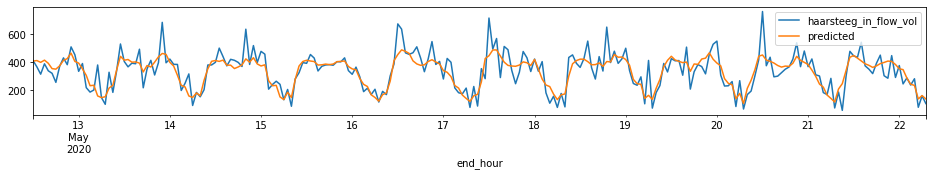

In [23]:
ddd["2020-05-12 12:00:00":"2020-05-23 12:00:00"].plot(figsize=(16, 2))

In [24]:
mean_absolute_error(y_predicted, y)

71.21969545545815

In [25]:
y.describe()

count    3001.000000
mean      329.935479
std       149.910607
min        50.226116
25%       229.487956
50%       327.275129
75%       415.134224
max      2401.628363
Name: haarsteeg_in_flow_vol, dtype: float64

In [26]:
np.sum(df_dry["haarsteeg_in_flow_vol"]), np.sum(df_dry["haarsteeg_flow_value"])

(990495.8632683358, 1011531.018833333)

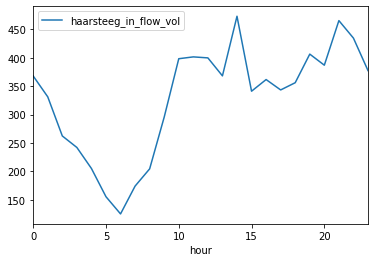

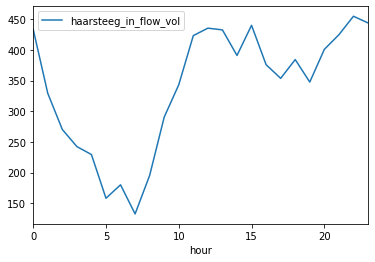

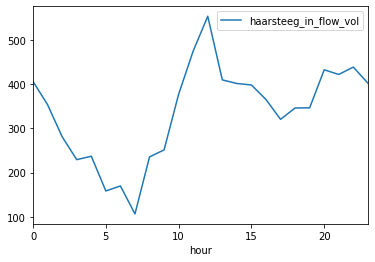

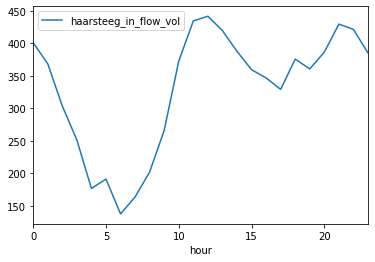

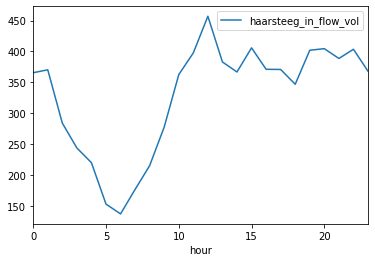

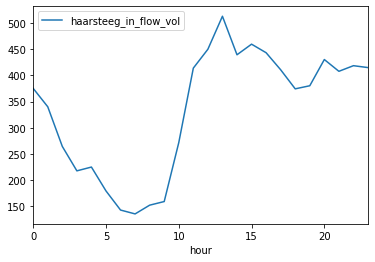

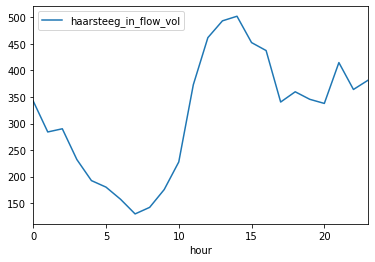

In [28]:
df = df_grouped[["haarsteeg_in_flow_vol", "hour", "weekday"]].copy()
ss = df.groupby(["weekday", "hour"]).mean()
for i in range(7):
    ss.loc[i].plot()

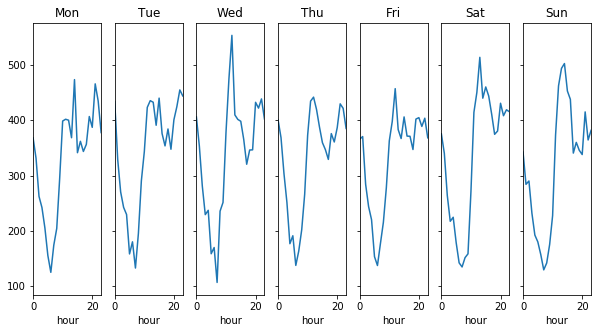

In [29]:
fig, ((ax0, ax1, ax2, ax3, ax4, ax5, ax6)) = plt.subplots(
    nrows=1, ncols=7, sharey=True, figsize=(10, 5)
)

ss.loc[0].plot(ax=ax0).set_title("Mon")
ss.loc[1].plot(ax=ax1).set_title("Tue")
ss.loc[2].plot(ax=ax2).set_title("Wed")
ss.loc[3].plot(ax=ax3).set_title("Thu")
ss.loc[4].plot(ax=ax4).set_title("Fri")
ss.loc[5].plot(ax=ax5).set_title("Sat")
ss.loc[6].plot(ax=ax6).set_title("Sun")
ax0.get_legend().remove()
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
ax5.get_legend().remove()
ax6.get_legend().remove()